# PacWave Resource Assesment

This example notebook provides an example using MHKiT to perform a resource assesment similar to Dunkel et. al at the PACWAVE site following the IEC 62600-101 where applicable. PacWave is an open ocean, grid-connected, full-scale test facility consisting of two sites for wave energy conversion technology testing located just a few miles from the deep-water port of Newport, Oregon. This example notebook performs a similar analysis using omni-directional wave data from a nearby NDBC buoy and replicates plots performed by Dunkel et. al and IEC TS 62600-101 using this data.

Dunkle, Gabrielle, et al. "PacWave Wave Resource Assessment." (2020).

In [1]:
import mhkit
from mhkit.wave import resource, performance, graphics
from sklearn.mixture import GaussianMixture
from mhkit.wave.io import ndbc
import matplotlib.pyplot as plt
from matplotlib import colors 
from scipy import stats
import pandas as pd
import numpy as np
import calendar
import folium
import os

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Buoy Location

The NDBC bouy is locatated further from shore than the PACWAVE sites as can be seen in the map below. The buoy used in this analysis is NDBC buoy 46050 shown using a blue indicator in the map below. The anaysis here will focus on PACWAVE south which is approximatly 40 km closer to shore than the NDBC buoy.

In [2]:
m = folium.Map(location=[44.613600975457715, -123.74317583354498], zoom_start=9, tiles="Stamen Terrain", control_scale = True)

tooltip = "NDBC 46050"
folium.Marker([44.669, -124.546], popup="<i> Water depth: 160 m</i>", tooltip=tooltip).add_to(m)

tooltip = "PACWAVE North"
folium.Marker([44.69, -124.13472222222222], tooltip=tooltip, icon=folium.Icon(color='green',icon="th-large")).add_to(m)
tooltip = "PACWAVE South"
folium.Marker([44.58444444444444, -124.2125], tooltip=tooltip, icon=folium.Icon(color='red', icon="th")).add_to(m)

m.save("index.png")

m

## Import Data from NDBC

Data can be imported from the NDBC buoy using MHKiT's NDBC submodule. At the top of this script we have already imported this module using the call`from mhkit.wave.io import ndbc`.  Here, we will use the `available_data` function to ask the NDBC servers what data is available for buoy 46050. We will also need to specify what parameter we are interested in. In this case we are requesting wave spectral wave density data which NDBC uses the keyword 'sweden'. We then pass the data of interest using the filenames of the returned data into the `request_data` function to return the requested data from the NDBC data.

In [3]:
# Spectral wave density for buoy 46050
parameter = 'swden'
buoy_number = '46050' 

# Request list of available files
ndbc_available_data= ndbc.available_data(parameter, buoy_number)

# Pass file names to NDBC and request the data
filenames = ndbc_available_data['filename']
ndbc_requested_data = ndbc.request_data(parameter, filenames)

ndbc_requested_data['2020']

,#YY,MM,DD,hh,mm,.0200,.0325,.0375,.0425,.0475,...,.3300,.3400,.3500,.3650,.3850,.4050,.4250,.4450,.4650,.4850
0,2020,1,1,0,40,0.0,0.0,0.00,2.28,2.99,...,0.19,0.22,0.15,0.12,0.12,0.06,0.04,0.03,0.02,0.02
1,2020,1,1,1,40,0.0,0.0,0.37,3.30,3.12,...,0.20,0.15,0.14,0.14,0.07,0.05,0.04,0.02,0.03,0.01
2,2020,1,1,2,40,0.0,0.0,0.00,4.80,5.16,...,0.07,0.18,0.14,0.10,0.13,0.08,0.04,0.02,0.01,0.01
3,2020,1,1,3,40,0.0,0.0,0.00,1.70,1.38,...,0.30,0.14,0.11,0.08,0.10,0.03,0.03,0.03,0.01,0.00
4,2020,1,1,4,40,0.0,0.0,0.24,5.72,7.90,...,0.12,0.18,0.07,0.10,0.12,0.04,0.03,0.03,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,2020,12,31,19,40,0.0,0.0,0.00,0.00,0.00,...,0.11,0.08,0.08,0.08,0.03,0.02,0.01,0.01,0.01,0.01
8617,2020,12,31,20,40,0.0,0.0,0.00,0.00,0.99,...,0.07,0.10,0.06,0.06,0.05,0.04,0.03,0.03,0.01,0.01
8618,2020,12,31,21,40,0.0,0.0,0.00,0.00,0.01,...,0.05,0.06,0.06,0.06,0.04,0.03,0.03,0.02,0.01,0.01
8619,2020,12,31,22,40,0.0,0.0,0.00,0.00,0.93,...,0.10,0.09,0.09,0.10,0.04,0.03,0.02,0.02,0.01,0.01


### Create datetime index

The data returned from NDBC includes seperate columns for Year, month, day, ect. as shown above. MHKiT has a builtin function to convert these seperate columns into a DateTime index for the DataFrame into a Datetime index and remove them from the data leaving only the frequency data. The resultant DataFrame is shown below.

In [4]:
ndbc_data={}
# Create a Datetime Index and remove NOAA date columns for each year
for year in ndbc_requested_data:
    year_data = ndbc_requested_data[year]
    ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)
    
ndbc_data['2020']

,0.0200,0.0325,0.0375,0.0425,0.0475,0.0525,0.0575,0.0625,0.0675,0.0725,...,0.3300,0.3400,0.3500,0.3650,0.3850,0.4050,0.4250,0.4450,0.4650,0.4850
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:40:00,0.0,0.0,0.00,2.28,2.99,0.00,0.00,2.91,7.23,10.65,...,0.19,0.22,0.15,0.12,0.12,0.06,0.04,0.03,0.02,0.02
2020-01-01 01:40:00,0.0,0.0,0.37,3.30,3.12,0.94,1.49,3.13,8.58,12.09,...,0.20,0.15,0.14,0.14,0.07,0.05,0.04,0.02,0.03,0.01
2020-01-01 02:40:00,0.0,0.0,0.00,4.80,5.16,0.66,1.44,4.19,14.32,26.21,...,0.07,0.18,0.14,0.10,0.13,0.08,0.04,0.02,0.01,0.01
2020-01-01 03:40:00,0.0,0.0,0.00,1.70,1.38,0.00,0.47,2.91,15.89,32.12,...,0.30,0.14,0.11,0.08,0.10,0.03,0.03,0.03,0.01,0.00
2020-01-01 04:40:00,0.0,0.0,0.24,5.72,7.90,2.75,0.59,4.39,17.49,18.75,...,0.12,0.18,0.07,0.10,0.12,0.04,0.03,0.03,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:40:00,0.0,0.0,0.00,0.00,0.00,6.15,21.06,28.97,21.23,20.75,...,0.11,0.08,0.08,0.08,0.03,0.02,0.01,0.01,0.01,0.01
2020-12-31 20:40:00,0.0,0.0,0.00,0.00,0.99,5.20,21.62,26.23,27.02,32.43,...,0.07,0.10,0.06,0.06,0.05,0.04,0.03,0.03,0.01,0.01
2020-12-31 21:40:00,0.0,0.0,0.00,0.00,0.01,0.58,6.02,21.26,18.66,13.60,...,0.05,0.06,0.06,0.06,0.04,0.03,0.03,0.02,0.01,0.01


## Calculate QoIs form Spectral Data

Here we will calculate quantities of interest(QoIs) using the spectral data by applying the appropriate MHKiT function, appending the results to a list, then combining all the lists into a single DataFrame. 

In [5]:
# Intialize empty lists to store the results from each year
Hm0_list=[]
Te_list=[]
J_list=[]
Tp_list=[]
Tz_list=[]

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    data_raw = ndbc_data[year]
    year_data = data_raw[data_raw != 999.0].dropna()
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append(resource.energy_period(year_data.T))
    J_list.append(resource.energy_flux(year_data.T, h=399.))
    Tp_list.append(resource.peak_period(year_data.T))
    Tz_list.append(resource.average_zero_crossing_period(year_data.T))
    
# Concatenate list of Series into a single DataFrame
Te = pd.concat(Te_list ,axis=0)
Tp = pd.concat(Tp_list ,axis=0)
Hm0 = pd.concat(Hm0_list ,axis=0)
J = pd.concat(J_list ,axis=0)
Tz = pd.concat(Tz_list ,axis=0)
data = pd.concat([Hm0, Te, Tp, J, Tz],axis=1)

# Calculate wave steepness
data['Sm'] = data.Hm0 / (9.81/(2*np.pi) * data.Tz**2)

# Drop any NaNs created from the calculation of Hm0 or Te
data.dropna(inplace=True)
# Sort the DateTime index
data.sort_index(inplace=True)
#data

C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **

## Average Annual Scatter Table

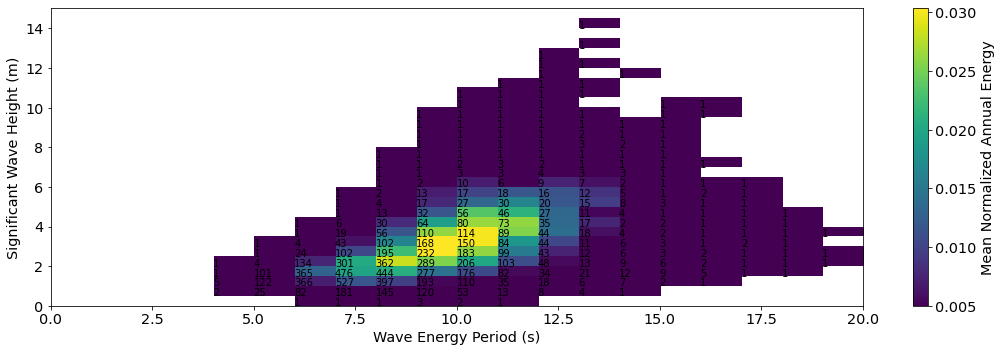

In [7]:
data_clean = data[data.Hm0 < 20]
sigma = data_clean.J.std()
data_clean = data_clean[data_clean.J > (data_clean.J.mean() - 0.9* sigma)]

Hm0=data_clean.Hm0.values
Te=data_clean.Te.values
J=data_clean.J.values
data= pd.DataFrame(dict(Hm0=Hm0, Te=Te, J=J), index=data_clean.index)

Hm0_bin_size = 0.5
Hm0_edges = np.arange(0,15+Hm0_bin_size,Hm0_bin_size)
Te_bin_size = 1
Te_edges = np.arange(0, 20+Te_bin_size,Te_bin_size)

fig = mhkit.wave.graphics.plot_avg_annual_scatter_table(Hm0, Te, J, time_index=data_clean.index, Hm0_bin_size=None, Te_bin_size=None, Hm0_edges=Hm0_edges, Te_edges=Te_edges)

## Wave Power by Month

--------------------------------------------
Hm0 max:3.1134, month: 12
Hm0 min:1.4445, month: 8
--------------------------------------------
Te max:10.305, month: 1
Te min:7.1154, month: 7
--------------------------------------------
Tp max:12.5, month: 1
Tp min:8.3333, month: 7
--------------------------------------------
J max:48889.5105, month: 12
J min:7212.2974, month: 8
--------------------------------------------
Tz max:7.9858, month: 1
Tz min:5.7369, month: 7
--------------------------------------------
Sm max:0.0313, month: 12
Sm min:0.0265, month: 9


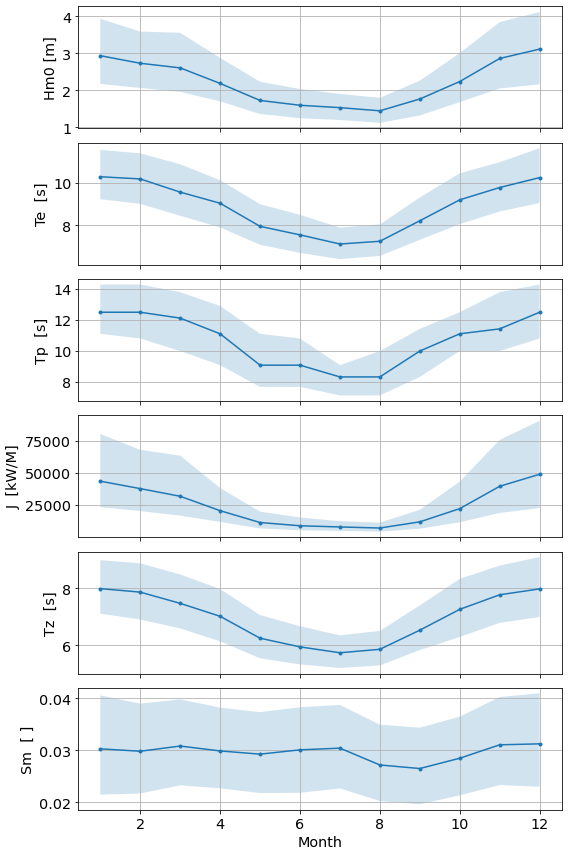

In [8]:
months=data_clean.index.month
data_group=data_clean.groupby(months)

QoIs = data_clean.keys()
fig, axs = plt.subplots(len(QoIs),1, figsize=(8, 12), sharex=True)
#shade between 25% and 75%
QoIs = data_clean.keys()
for i in range(len(QoIs)):
    QoI = QoIs[i]
    axs[i].plot(data_group.median()[QoI], marker='.')

    axs[i].fill_between(months.unique(),
                        data_group.describe()[QoI,   '25%'],
                        data_group.describe()[QoI,   '75%'],
                        alpha=0.2)
    axs[i].grid()
    mx = data_group.median()[QoI].max()
    mx_month= data_group.median()[QoI].argmax()+1
    mn = data_group.median()[QoI].min()
    mn_month= data_group.median()[QoI].argmin()+1
    print('--------------------------------------------')
    print(f'{QoI} max:{np.round(mx,4)}, month: {mx_month}')
    print(f'{QoI} min:{np.round(mn,4)}, month: {mn_month}')

plt.setp(axs[5], xlabel='Month')

plt.setp(axs[0], ylabel=f'{QoIs[0]} [m]')
plt.setp(axs[1], ylabel=f'{QoIs[1]}  [s]')
plt.setp(axs[2], ylabel=f'{QoIs[2]}  [s]')
plt.setp(axs[3], ylabel=f'{QoIs[3]}  [kW/M]')
plt.setp(axs[4], ylabel=f'{QoIs[4]}  [s]')
plt.setp(axs[5], ylabel=f'{QoIs[5]}  [ ]')


plt.tight_layout()

plt.savefig('40650QoIs.png')

## Montly Cumulative Distribution

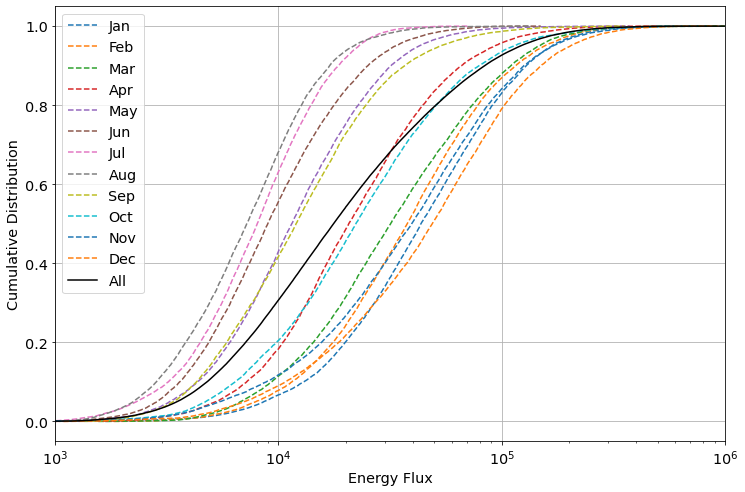

In [9]:
cumSum={}
for month in data_clean.index.month.unique():    
    F = mhkit.river.resource.exceedance_probability(data_clean[data_clean.index.month==month].J)
    cumSum[month] = 1-F/100
    cumSum[month].sort_values('F', inplace=True)
plt.figure(figsize=(12,8) )
for month in data_clean.index.month.unique():
    plt.semilogx(data_clean.loc[cumSum[month].index].J, cumSum[month].F, '--', label=calendar.month_abbr[month])

F = mhkit.river.resource.exceedance_probability(data_clean.J)
F.sort_values('F', inplace=True)
plt.semilogx(data_clean.loc[F.index].J, 1-F/100, 'k-', fillstyle='none', label='All')

plt.xlim([1000, 1E6])    
plt.grid()
plt.xlabel('Energy Flux')
plt.ylabel('Cumulative Distribution')
plt.legend()

plt.savefig('40650CumSumMonths.png')

## Extreme Sea States

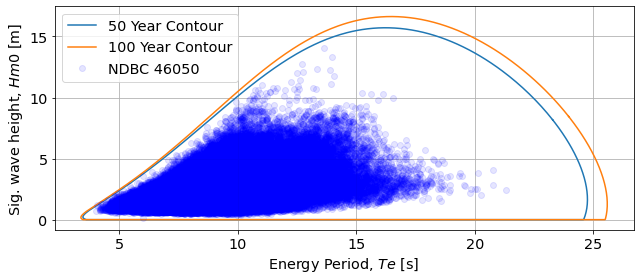

In [10]:
# Delta time of sea-states 
dt = (data_clean.index[2]-data_clean.index[1]).seconds  

# Return period (years) of interest
period = 100  
Hm0_contour_100, Te_contour_100, PCA = resource.environmental_contour(data.Hm0, 
                                                                      data.Te, 
                                                                      dt, period, return_PCA=True)
period = 50
Hm0_contour_50, Te_contour_50 = resource.environmental_contour(data.Hm0, 
                                                               data.Te, 
                                                               dt, period, PCA=PCA)

fig, ax = plt.subplots(figsize=(9,4))
ax = graphics.plot_environmental_contour(np.array(data_clean.Te), np.array(data_clean.Hm0), 
                                         np.array([Te_contour_50, Te_contour_100]).T, 
                                         np.array([Hm0_contour_50,Hm0_contour_100]).T , 
                                         data_label='NDBC 46050', 
                                         contour_label=['50 Year Contour','100 Year Contour'],
                                         x_label = 'Energy Period, $Te$ [s]',
                                         y_label = 'Sig. wave height, $Hm0$ [m]', 
                                         ax=ax)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('environmentalContour.png')  

In [11]:
print(Hm0_contour_50.max(), Te_contour_50[Hm0_contour_50.argmax()])
print(Hm0_contour_100.max(), Te_contour_100[Hm0_contour_100.argmax()])

15.709501488368842 16.235216168588583
16.627857735929652 16.435667814392655


## Calculate Sea State Representative Clusters

[Text(0.5, 0, 'Sig. wave height, $Hm0$ [m')]

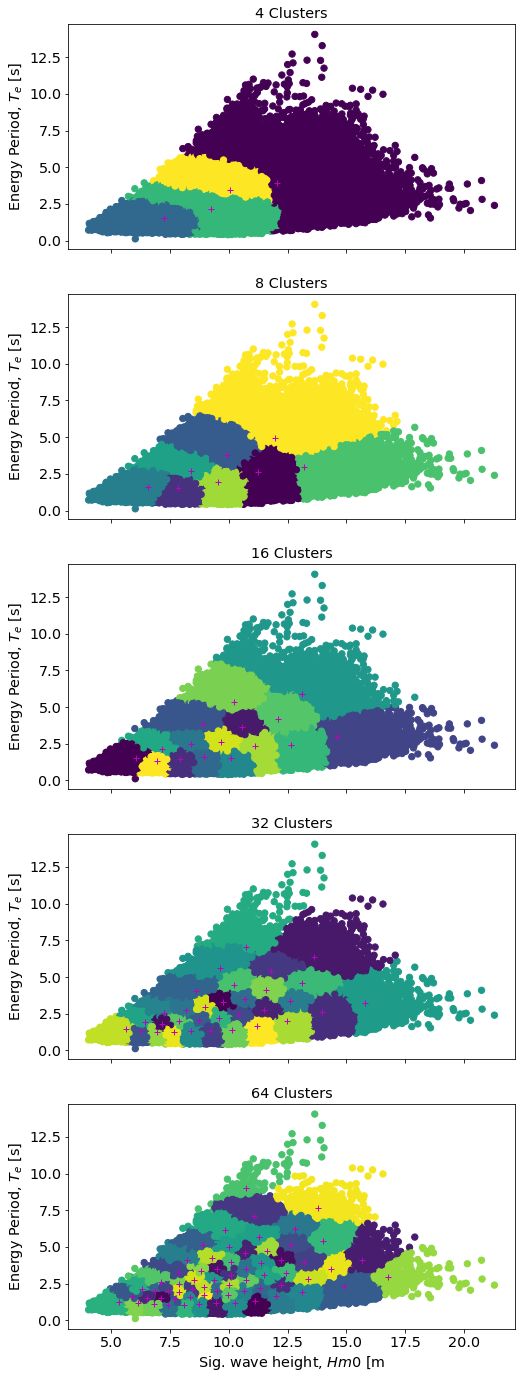

In [12]:
# Compute Gaussian Mixture Model for each number of clusters
Ns= [4, 8, 16, 32, 64]
X = np.vstack((data_clean.Te.values, data_clean.Hm0.values)).T
fig, axs = plt.subplots(len(Ns),1, figsize=(8, 24), sharex=True)

results={}
for N in Ns:
    gmm = GaussianMixture(n_components=N).fit(X)

    # Save centers and weights
    result = pd.DataFrame(gmm.means_, columns=['Te','Hm0'])
    result['weights'] = gmm.weights_

    result['Tp'] = result.Te / 0.858
    results[N] = result
    
    
    labels = gmm.predict(X)
    
    i = Ns.index(N)
    axs[i].scatter(data_clean.Te.values, data_clean.Hm0.values, c=labels, s=40)
    axs[i].plot(result.Te, result.Hm0, 'm+')
    axs[i].title.set_text(f'{N} Clusters')
    plt.setp(axs[i], ylabel='Energy Period, $T_e$ [s]')
plt.setp(axs[len(Ns)-1], xlabel='Sig. wave height, $Hm0$ [m')    

## Save 1-year of data for WecOptTool

Choose 1-year of data to perform analysis one and save full spectrum for use by WecOptTool

In [13]:
year='1996'
data_raw = ndbc_data[str(year)]
data_year = data_raw[data_raw != 999.0].dropna()

output_folder='ToWecOptTool'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

data_year.to_csv(os.path.join(output_folder,'46050_1996.csv'))

#data_year

## Calculate Energy Flux

Calculate energy flux for each cluster and save results to file

In [14]:
w = ndbc_data[year].columns.values
f = w / 2*np.pi


for N in results:
    result = results[N]
    J=[]
    for i in range(len(result)):
        b = resource.bretschneider_spectrum(f, result.Tp[i], result.Hm0[i])
        J.extend([resource.energy_flux(b, h=399.).values[0][0]])
    
    result['J']  = J
    results[N] = result
    
    #result.to_csv(f'toWecOpt\\{N}_cluster.csv', index=False)

C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Plot Energy Flux Matrix

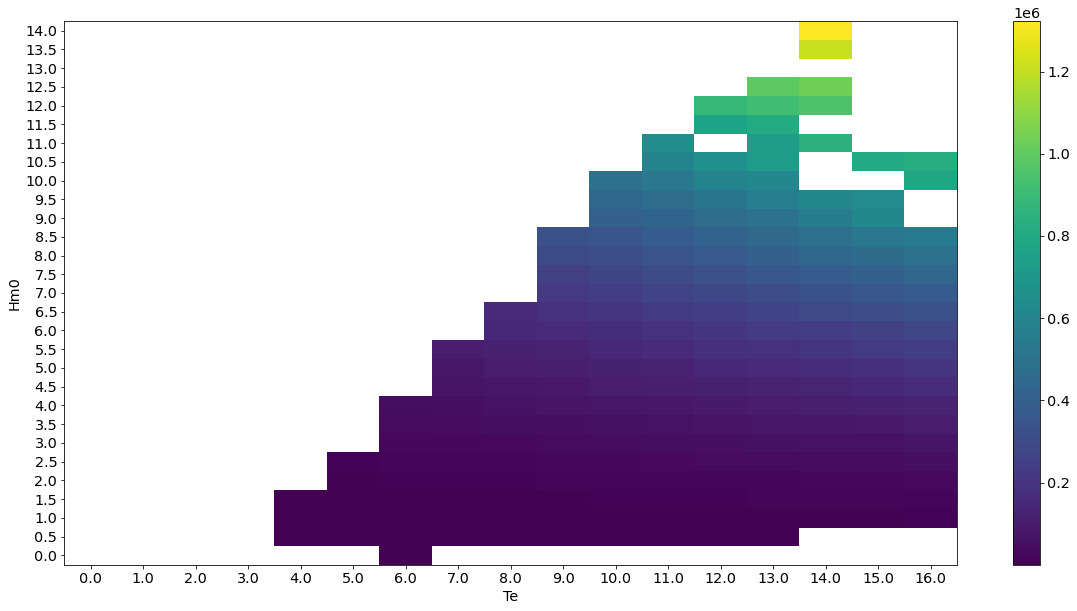

In [15]:
Hm0_max=14
Te_max=16

reduce_factor=1

Hm0_bin_size = 0.5/reduce_factor
Te_bin_size = 1.0/reduce_factor

Hm0_bins = np.arange(0, Hm0_max + Hm0_bin_size, Hm0_bin_size)    
Te_bins = np.arange(0, Te_max + Te_bin_size, Te_bin_size)
#JM = mhkit.wave.performance.wave_energy_flux_matrix(data_clean.Hm0, data_clean.Te, data_clean.J, 'mean', Hm0_bins, Te_bins)
JM = performance.wave_energy_flux_matrix(data_clean.Hm0, data_clean.Te, data_clean.J, 'mean', Hm0_bins, Te_bins)


fig, ax = plt.subplots(figsize=(20, 10))
ax = graphics.plot_matrix(JM, ax=ax, show_values=False)
#L = mhkit.wave.performance.capture_length(P, data_clean.J) 

#maep_timeseries = mhkit.wave.performance.mean_annual_energy_production_timeseries(L, data_clean.J)
#print("MAEP from timeseries = ", maep_timeseries)

In [16]:
Jmean, xe, ye, bn = stats.binned_statistic_2d(data_clean.Hm0, data_clean.Te, data_clean.J,
                                                  statistic='sum',bins=[Te_bins, Hm0_bins])
#H, xe,ye = np.histogram2d(data_clean.Hm0, data_clean.Te, bins=[Te_bins, Hm0_bins], density=True)

# Incident  Wave PowerResults

## Full Sea State


In [17]:
nHours = (data_clean.index[1] - data_clean.index[0]).seconds/3600
Total = data_clean.J.sum() * nHours
print(f'{Total} (W*hr)/m')

6729597955.922245 (W*hr)/m


## 2D Histogram Result

In [18]:
x = Jmean.flatten() 
x = x[~np.isnan(x)]
hist_result = np.round(x.sum()/Total,4)
print(f'{hist_result} = (2D Histogram J) / (1-year total J) ')

0.9484 = (2D Histogram J) / (1-year total J) 


## K-means

In [19]:
ratios={}
for N in results:
    ratios[N] = np.round((results[N].J*len(data_clean)* results[N].weights).sum()/Total,4)
    
pd.Series(ratios)

4     0.8951
8     0.9194
16    0.9538
32    0.9721
64    0.9858
dtype: float64

In [20]:
np.linspace(0,48,5)

array([ 0., 12., 24., 36., 48.])